# Tally α

## Composition

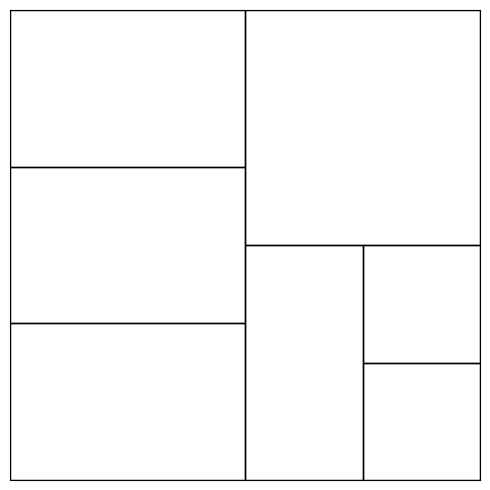

In [1]:
from tally import H, V, e

composition = V(e, e, e) | e & H(e, e & e)

composition.plot()

## Tree

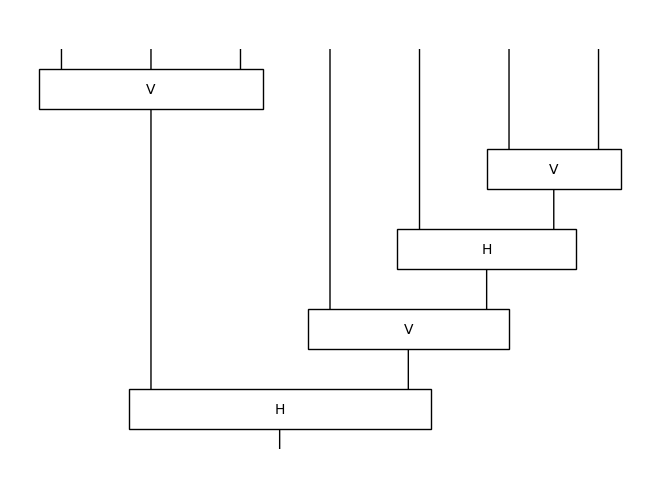

In [2]:
diagram = composition.to_diagram()
diagram.draw()

## Circuit

In [3]:
from numpy.random import rand, seed; seed(42)

from discopy.monoidal import PRO
from discopy.markov import Box, Functor, Category
from discopy.quantum import qubit, Ty, Circuit, Discard, Measure, IQPansatz, Bits

DEPTH = 1

def ansatz(n_qubits, params):
    return IQPansatz(n_qubits, params)\
        >> Discard((n_qubits - 1) // 2) @ qubit @ Discard(n_qubits // 2)

params0 = rand(6)

F = lambda params: Functor(
    ob={PRO(1): qubit},
    ar={Box('H', 3, 1): ansatz(3, params[0:2].reshape(1, 2)),
        Box('V', 3, 1): ansatz(3, params[2:4].reshape(1, 2)),
        Box('H', 2, 1): ansatz(2, params[4:5].reshape(1, 1)),
        Box('V', 2, 1): ansatz(2, params[5:6].reshape(1, 1))},
    cod=Category(Ty, Circuit))

F0 = F(params0)

circuit = F0(diagram) >> Measure() >> Bits(0)[::-1]

In [4]:
import warnings; warnings.filterwarnings("ignore")
from pytket.extensions.qiskit import AerBackend, tk_to_qiskit

tk_to_qiskit(circuit.to_tk()).draw(fold=-1)

┌───┐                                                                                       
q_0: ┤ H ├───────■───────────────────────────────────────────────────────────────────────────────
     ├───┤ ┌─────┴──────┐                   ┌───┐                                             ┌─┐
q_1: ┤ H ├─┤ Rz(4.5993) ├──────■────────────┤ H ├─────────────────────────────────────■───────┤M├
     ├───┤ └────────────┘┌─────┴──────┐     └───┘                                     │       └╥┘
q_2: ┤ H ├───────────────┤ Rz(3.7615) ├───────────────────────────────────────────────┼────────╫─
     ├───┤               └────────────┘                                   ┌───┐┌──────┴──────┐ ║ 
q_3: ┤ H ├────────────────────────────────────────────────────────■───────┤ H ├┤ Rz(0.98029) ├─╫─
     ├───┤                                            ┌───┐┌──────┴──────┐└───┘└─────────────┘ ║ 
q_4: ┤ H ├────────────────────────────────────■───────┤ H ├┤ Rz(0.98014) ├─────────────────────╫─
     ├───┤                   ┌───┐     ┌──────┴──────┐└───┘└─────────────┘                     ║ 
q_5: ┤ H ├───────■───────────┤ H ├─────┤ Rz(0.98029) ├─────────────────────────────────────────╫─
     ├───┤┌──────┴──────┐    └───┘     └─────────────┘                                         ║ 
q_6: ┤ H ├┤ Rz(0.98014) ├──────────────────────────────────────────────────────────────────────╫─
     └───┘└─────────────┘                                                                      ║ 
c: 1/══════════════════════════════════════════════════════════════════════════════════════════╩═
                                                                                               0

In [5]:
backend = AerBackend()

evaluate = lambda F, composition: float((
    F(composition.to_diagram()) >> Measure() >> Bits(0)[::-1]).eval(
        backend=backend, compilation=backend.default_compilation_pass()))

evaluate(F0, composition)

0.4169921875

## Repeat

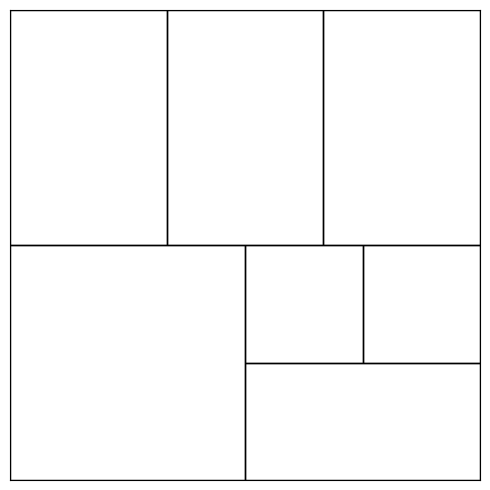

In [6]:
def rotate(composition):
    for X, Y in [(H, V), (V, H)]:
        if isinstance(composition, X):
            return Y(*map(rotate, composition.terms))
    return composition

rotate(composition).plot()

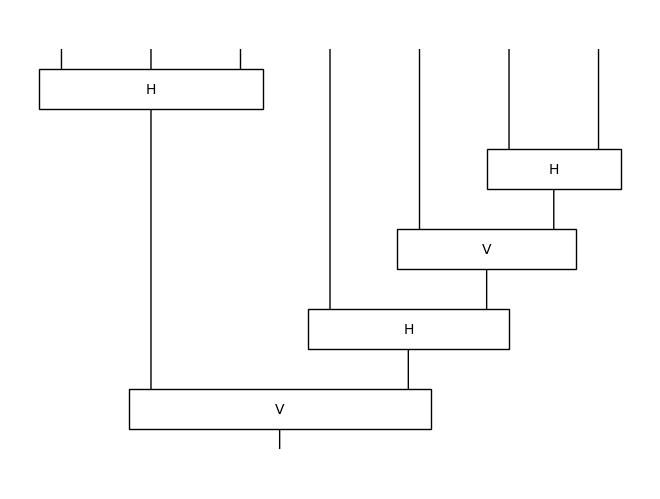

In [7]:
rotate(composition).to_diagram().draw()

In [8]:
circuit2 = F0(rotate(composition).to_diagram()) >> Measure()
tk_to_qiskit(circuit2.to_tk()).draw(fold=-1)

┌───┐                                                                                       
q_0: ┤ H ├───────■───────────────────────────────────────────────────────────────────────────────
     ├───┤ ┌─────┴──────┐                   ┌───┐                                             ┌─┐
q_1: ┤ H ├─┤ Rz(2.3533) ├──────■────────────┤ H ├─────────────────────────────────────■───────┤M├
     ├───┤ └────────────┘┌─────┴──────┐     └───┘                                     │       └╥┘
q_2: ┤ H ├───────────────┤ Rz(5.9735) ├───────────────────────────────────────────────┼────────╫─
     ├───┤               └────────────┘                                   ┌───┐┌──────┴──────┐ ║ 
q_3: ┤ H ├────────────────────────────────────────────────────────■───────┤ H ├┤ Rz(0.98014) ├─╫─
     ├───┤                                            ┌───┐┌──────┴──────┐└───┘└─────────────┘ ║ 
q_4: ┤ H ├────────────────────────────────────■───────┤ H ├┤ Rz(0.98029) ├─────────────────────╫─
     ├───┤                   ┌───┐     ┌──────┴──────┐└───┘└─────────────┘                     ║ 
q_5: ┤ H ├───────■───────────┤ H ├─────┤ Rz(0.98014) ├─────────────────────────────────────────╫─
     ├───┤┌──────┴──────┐    └───┘     └─────────────┘                                         ║ 
q_6: ┤ H ├┤ Rz(0.98029) ├──────────────────────────────────────────────────────────────────────╫─
     └───┘└─────────────┘                                                                      ║ 
c: 1/══════════════════════════════════════════════════════════════════════════════════════════╩═
                                                                                               0

In [9]:
evaluate(F0, rotate(composition))

0.4453125

### Both compositions have scores around 50%: Tally has no opinion...

### Time to do some learning!

## Learn

### Say that we like our first example, but not its rotation.

In [10]:
data = {composition: 1, rotate(composition): 0}

In [11]:
from time import time
import numpy as np
import noisyopt

i, start, losses = 0, time(), []

def callback(params):
    global i
    i += 1
    losses.append(loss(params))
    print("Step {}: {}".format(i, params))

def loss(params):
    return np.mean(np.array([
        (value - evaluate(F(params), composition)) ** 2
        for composition, value in data.items()]))

experiment = noisyopt.minimizeSPSA(
    loss, params0, paired=False, callback=callback, niter=21)
experiment

Step 1: [0.3832536  0.95942779 0.72328046 0.60737197 0.14730516 0.14728104]
Step 2: [0.36015396 0.98252743 0.70018082 0.63047161 0.12420552 0.1241814 ]
Step 3: [0.30196005 0.92433352 0.64198691 0.5722777  0.0660116  0.06598748]
Step 4: [0.2777767  0.90015017 0.66617025 0.59646104 0.09019495 0.04180414]
Step 5: [0.23014882 0.94777805 0.71379814 0.64408893 0.13782283 0.08943202]
Step 6: [0.15969279 0.87732202 0.64334211 0.5736329  0.06736681 0.15988805]
Step 7: [0.11629731 0.83392654 0.68673759 0.53023742 0.11076229 0.11649257]
Step 8: [0.04453437 0.90568948 0.75850052 0.45847448 0.03899935 0.04472963]
Step 9: [0.02761872 0.88877382 0.74158487 0.44155883 0.02208369 0.06164528]
Step 10: [-0.00638411  0.92277665  0.70758204  0.407556   -0.01191913  0.02764246]
Step 11: [ 0.02780056  0.88859199  0.74176671  0.37337133 -0.0461038  -0.00654221]
Step 12: [ 0.05369928  0.86269326  0.76766543  0.34747261 -0.02020508 -0.03244093]
Step 13: [0.01499604 0.82399002 0.80636868 0.30876936 0.01849817 0.

 message: terminated after reaching max number of iterations
 success: True
     fun: 0.014839649200439453
       x: [ 7.158e-02  8.801e-01  8.630e-01  1.892e-01 -7.331e-02
            1.245e-01]
     nit: 21
    nfev: 42

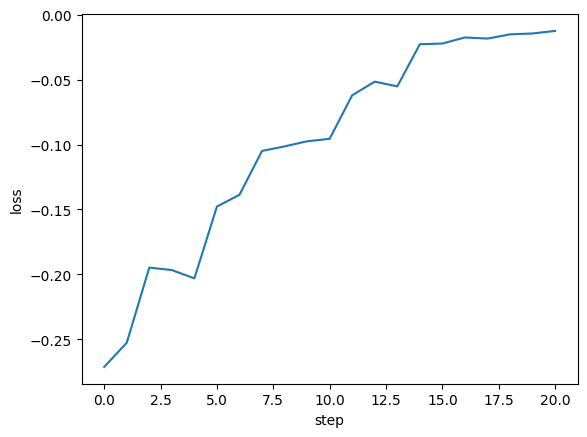

In [12]:
import matplotlib.pyplot as plt

plt.plot(-np.array(losses))
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [13]:
import warnings; warnings.filterwarnings("ignore")
from pytket.extensions.qiskit import AerBackend, tk_to_qiskit

result = {c: evaluate(F(experiment.x), c) for c in data}
result

{(V(e, e, e) | e & (e | e & e)): 0.83984375,
 H(e, e, e) & (e | e & (e | e)): 0.05859375}

### Tally's score have come close enough to our human judgement...

### Our first quantum drawing experiment is a success!